In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from diff_ml import Approximator



In [2]:
print(torch.cuda.is_available(),torch.cuda.get_device_name(0))
cpu_device = torch.device("cpu")
cuda_device = torch.device("cuda")
device =cuda_device if torch.cuda.is_available() else cpu_device
device

True NVIDIA RTX A2000 8GB Laptop GPU


device(type='cuda')

In [3]:
class BlackScholes:
    def __init__(self,expiry=1.0, strike=100.0, rate=0.05, vol=0.2):
        self.expiry = expiry
        self.strike = strike
        self.rate = rate
        self.vol = vol
    
    def price(self, spot):
        d1 = (np.log(spot / self.strike) + (self.rate + 0.5 * self.vol ** 2) * self.expiry) / (self.vol * np.sqrt(self.expiry))
        d2 = d1 - self.vol * np.sqrt(self.expiry)
        return spot * norm.cdf(d1) - self.strike * np.exp(-self.rate * self.expiry) * norm.cdf(d2),norm.cdf(d1)
        
    

    def get_samples(self,spot_prices,random_seed=None,as_tensor=False):
        if random_seed is not None:
            np.random.seed(random_seed)
        num_samples = len(spot_prices)
        price_at_expiry = spot_prices * np.exp((self.rate - 0.5 * self.vol ** 2) * self.expiry + self.vol * np.sqrt(self.expiry) * np.random.standard_normal(size=num_samples))
        value_per_path = np.maximum(price_at_expiry - self.strike, 0)* np.exp(-self.rate * self.expiry)
        derivative_per_path = (price_at_expiry - self.strike >= 0) * np.exp(-self.rate * self.expiry) * (price_at_expiry / spot_prices)
        if as_tensor:
            value_per_path = torch.tensor(value_per_path, dtype=torch.float32).view(-1, 1).to(device)
            derivative_per_path = torch.tensor(derivative_per_path, dtype=torch.float32).view(-1, 1).to(device)
            spot_prices = torch.tensor(spot_prices, dtype=torch.float32).view(-1, 1).to(device)
        return spot_prices,value_per_path, derivative_per_path

In [4]:
bs = BlackScholes(strike=1.0,vol=0.1,expiry=0.5)

In [6]:
initial_price = np.linspace(0.5, 2, 10000)*bs.strike  # Initial stock price
real_price, real_delta = bs.price(initial_price)
x,y,grad_y = bs.get_samples(initial_price, random_seed=42,as_tensor=True)
x.device,y.device,grad_y.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [7]:
real_price.mean(),y.mean(),real_delta.mean(),grad_y.mean()

(np.float64(0.3516020217333227),
 tensor(0.3508, device='cuda:0'),
 np.float64(0.6831084126419135),
 tensor(0.6806, device='cuda:0'))

In [8]:
w  = np.exp( -  ((initial_price[:,None]-initial_price[None,:])/0.001)**2)
w = w / w.sum(axis=1, keepdims=True)

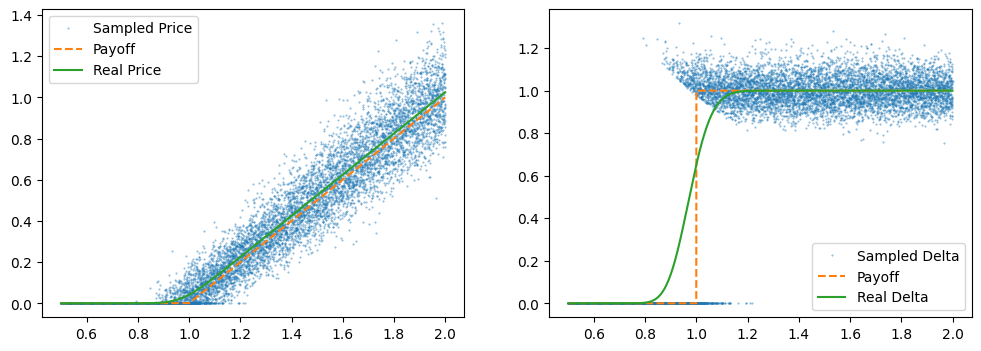

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(initial_price, y.cpu(), '.', markersize=1, label='Sampled Price',alpha=0.5)
plt.plot(initial_price,np.maximum(initial_price - bs.strike, 0), '--', markersize=1, label='Payoff')
plt.plot(initial_price, real_price, '-', markersize=1, label='Real Price')
plt.legend()
plt.subplot(1,2,2)
plt.plot(initial_price, grad_y.cpu().numpy(), '.', markersize=1, label='Sampled Delta',alpha=0.5)
plt.plot(initial_price,(initial_price - bs.strike >= 0), '--', markersize=1, label='Payoff')
plt.plot(initial_price, real_delta, '-', markersize=1, label='Real Delta')
plt.legend()

In [10]:
model = Approximator(1,layer_sizes=[20],learning_rate = 0.0005).to(device)

In [11]:
model.layers

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Softplus(beta=10.0, threshold=20.0)
  (2): Linear(in_features=20, out_features=1, bias=True)
)

In [14]:
x.shape,y.shape,grad_y.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]), torch.Size([10000, 1]))

In [20]:
model.train(2000,x,y,grad_y,lambda_grad=0.5)

Epoch 0, Loss: 0.021155, Value Loss: 0.007857, Grad Loss: 0.034453
Epoch 200, Loss: 0.020993, Value Loss: 0.007856, Grad Loss: 0.034130
Epoch 400, Loss: 0.020854, Value Loss: 0.007856, Grad Loss: 0.033853
Epoch 600, Loss: 0.020728, Value Loss: 0.007855, Grad Loss: 0.033601
Epoch 800, Loss: 0.020621, Value Loss: 0.007856, Grad Loss: 0.033386
Epoch 1000, Loss: 0.020559, Value Loss: 0.007856, Grad Loss: 0.033262
Epoch 1200, Loss: 0.020526, Value Loss: 0.007857, Grad Loss: 0.033194
Epoch 1400, Loss: 0.020509, Value Loss: 0.007857, Grad Loss: 0.033160
Epoch 1600, Loss: 0.020500, Value Loss: 0.007858, Grad Loss: 0.033142
Epoch 1800, Loss: 0.020494, Value Loss: 0.007858, Grad Loss: 0.033129


In [21]:
# ===== Generate Test Data =====
n_test = 1000
initial_price_test = np.sort(np.random.uniform(0.5, 2, n_test))*bs.strike  # Initial stock price
real_price_test, real_delta_test = bs.price(initial_price_test)
x_test,_,_ = bs.get_samples(initial_price_test, random_seed=0,as_tensor=True)
y_pred_test,grad_pred_test = model.predict(x_test)

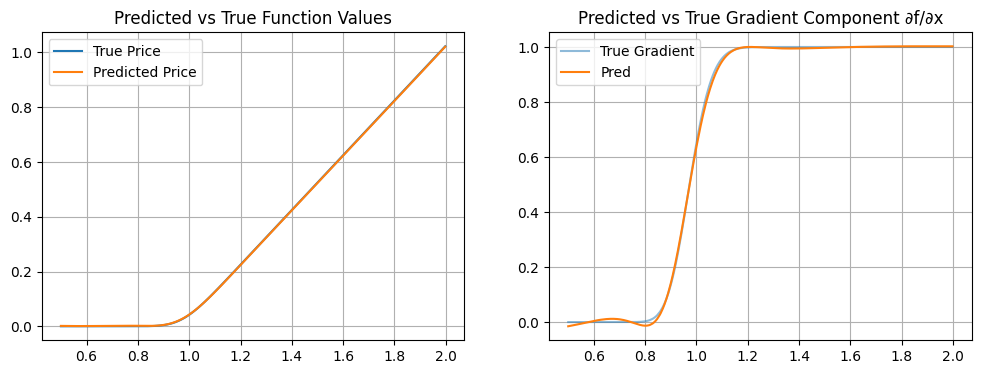

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(initial_price_test, real_price_test, '-', markersize=1, label='True Price')
plt.plot(initial_price_test, y_pred_test, '-', markersize=1, label='Predicted Price')
plt.legend()
plt.title("Predicted vs True Function Values")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(initial_price_test, real_delta_test, '-', markersize=1, label='True Gradient',alpha=0.5)
plt.plot(initial_price_test, grad_pred_test, '-', markersize=1, label='Pred')
plt.title(r"Predicted vs True Gradient Component ∂f/∂x")
plt.legend()
plt.grid(True)



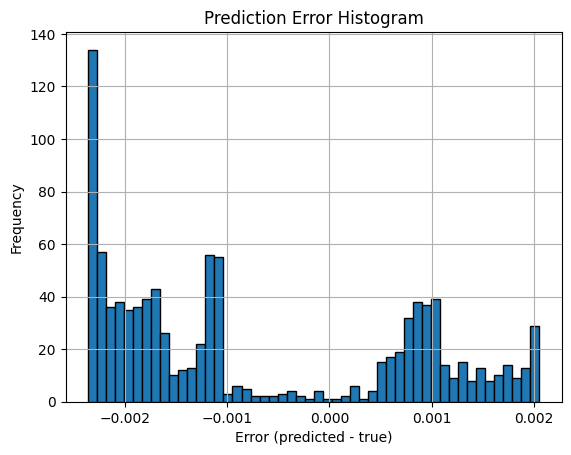

In [23]:
# ===== Value Error Histogram =====
errors = (y_pred_test - real_price_test)
plt.hist(errors, bins=50, edgecolor='black')
plt.title("Prediction Error Histogram")
plt.xlabel("Error (predicted - true)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
